Importation de tous les modules nécessaire pour la suite du code.

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from tqdm import tqdm
import os
import random
import networkx as nx
import seaborn as sns



Dans cette partie, on définit toutes les fonctions utiles pour la suite. par exemple les différents plots ou la partie dans laquelle on load les fichiers.dat

In [ ]:
# === 📌 1. Calcul des statistiques globales (moyenne et écart-type) ===
def compute_global_stats(data_dir):
    all_files = sorted(os.listdir(data_dir))

    x_min, x_max = float("inf"), float("-inf")
    y_min, y_max = float("inf"), float("-inf")
    
    all_pressures = []

    for file in all_files:
        df = pd.read_csv(os.path.join(data_dir, file), skiprows=1, sep=',', skipinitialspace=True,
                         names=["id", "x", "y", "pressure", "volume"])

        df["x"] = pd.to_numeric(df["x"], errors="coerce")
        df["y"] = pd.to_numeric(df["y"], errors="coerce")
        df["pressure"] = pd.to_numeric(df["pressure"], errors="coerce")
        df = df.dropna()

        if df.empty:
            continue

        x_min, x_max = min(x_min, df["x"].min()), max(x_max, df["x"].max())
        y_min, y_max = min(y_min, df["y"].min()), max(y_max, df["y"].max())

        all_pressures.extend(df["pressure"].values)

    p_mean = np.mean(all_pressures)
    p_std = np.std(all_pressures)

    return (x_min, x_max), (y_min, y_max), (p_mean, p_std)

# === 📌 2. Charger un fichier et appliquer la normalisation (Z-score pour pression) ===
def load_fluent_data(file_path, x_range, y_range, p_stats):
    df = pd.read_csv(file_path, skiprows=1, sep=',', skipinitialspace=True,
                     names=["id", "x", "y", "pressure", "volume"])

    df["x"] = pd.to_numeric(df["x"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")
    df["pressure"] = pd.to_numeric(df["pressure"], errors="coerce")
    df = df.dropna()

    if df.empty:
        raise ValueError(f"Erreur : les données de {file_path} sont vides après nettoyage !")

    # Normalisation Min-Max pour x et y
    x = (df["x"].values - x_range[0]) / (x_range[1] - x_range[0])
    y = (df["y"].values - y_range[0]) / (y_range[1] - y_range[0])

    # Normalisation Z-score pour la pression
    p_mean, p_std = p_stats
    pressures = (df["pressure"].values - p_mean) / p_std

    # Création des features
    x_features = np.vstack((x, y)).T

    # Création des arêtes via triangulation
    points = np.vstack((x, y)).T
    tri = Delaunay(points)
    edges = [(simplex[i], simplex[j]) for simplex in tri.simplices for i in range(3) for j in range(i + 1, 3)]
    edge_index = torch.tensor(edges, dtype=torch.long).t()

    # Création de l'objet Data pour PyTorch Geometric
    graph = Data(
        x=torch.tensor(x_features, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(pressures, dtype=torch.float)
    )

    return graph

# === 📌 3. Chargement du dataset avec normalisation globale ===
def load_dataset(data_dir, num_train, num_test):
    # Calculer les statistiques globales
    x_range, y_range, p_stats = compute_global_stats(data_dir)

    all_files = sorted(os.listdir(data_dir))
    selected_files = np.random.choice(all_files, num_train + num_test, replace=False)

    graphs = []
    for file in selected_files:
        graph = load_fluent_data(os.path.join(data_dir, file), x_range, y_range, p_stats)
        graphs.append(graph)

    train_graphs = graphs[:num_train]
    test_graphs = graphs[num_train:]

    return train_graphs, test_graphs, p_stats

# === 📌 4. Définition du GNN ===
class PressureGNN(nn.Module):
    def __init__(self):
        super(PressureGNN, self).__init__()
        self.layers = nn.ModuleList()

    def add_layer(self, layer_type, in_channels, out_channels, activation=None, batch_norm=False, dropout=0.0):
        layers = []
        if layer_type == GCNConv:
            layers.append(layer_type(in_channels, out_channels))
        elif layer_type == nn.Linear:
            layers.append(layer_type(in_channels, out_channels))
        elif layer_type == nn.Flatten:
            layers.append(layer_type())
        else:
            raise ValueError(f"Unsupported layer type: {layer_type}")

        if batch_norm:
            if layer_type == GCNConv or layer_type == nn.Linear:
                layers.append(nn.BatchNorm1d(out_channels))

        if activation:
            layers.append(activation())

        if dropout > 0:
            layers.append(nn.Dropout(dropout))

        self.layers.append(nn.Sequential(*layers))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for layer in self.layers:
            if isinstance(layer[0], GCNConv):
                x = layer[0](x, edge_index)
                x = layer[1:](x)
            else:
                x = layer(x)
        return x

# === 📌 5. Entraînement et évaluation ===
def train_gnn(model, train_loader, test_loader, optimizer, loss_fn, epochs, scheduler):
    train_losses, test_r2_scores = [], []
    a = 0
    for epoch in tqdm(range(epochs), desc="Entraînement du modèle"):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_fn(out.squeeze(), batch.y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Ajuster le taux d'apprentissage
        scheduler.step(avg_loss)

        test_r2 = evaluate_gnn(model, test_loader)
        test_r2_scores.append(test_r2)

        if a == 5:
            tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test R²: {test_r2:.4f}")
            a = 0
        else:
            a += 1

    return train_losses, test_r2_scores


def evaluate_gnn(model, data_loader):
    model.eval()
    all_targets, all_preds = [], []
    with torch.no_grad():
        for batch in data_loader:
            preds = model(batch).squeeze()
            all_preds.append(preds)
            all_targets.append(batch.y)
    return r2_score(torch.cat(all_targets).numpy(), torch.cat(all_preds).numpy())

# === 📌 6. Visualisation des edges ===
def plot_graph_edges(graph, title="Visualisation du graphe"):
    G = nx.Graph()
    for i, coords in enumerate(graph.x.numpy()):
        G.add_node(i, pos=(coords[0], coords[1]))
    edges = graph.edge_index.t().numpy()
    G.add_edges_from(edges)

    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color="blue", edge_color="black", node_size=30, alpha=0.8)
    plt.title(title)
    plt.show()

def plot_test_case(graph, predictions, p_min, p_max, title="Comparaison Prédiction vs Réel"):
    """Affiche le champ de pression réel et prédit sur un même plot."""

    # Dénormalisation des valeurs
    predictions_denorm = predictions * (p_max - p_min) + p_min
    targets_denorm = graph.y * (p_max - p_min) + p_min
    print(predictions_denorm.max())
    print(predictions.max())
    print(targets_denorm.max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Pression réelle
    sc1 = axes[0].scatter(graph.x[:, 0].numpy(), graph.x[:, 1].numpy(),
                          c=targets_denorm.numpy(), cmap="viridis", s=10)
    axes[0].set_title("Pression réelle")
    fig.colorbar(sc1, ax=axes[0])

    # Pression prédite
    sc2 = axes[1].scatter(graph.x[:, 0].numpy(), graph.x[:, 1].numpy(),
                          c=predictions_denorm.numpy(), cmap="viridis", s=10)
    axes[1].set_title("Pression prédite")
    fig.colorbar(sc2, ax=axes[1])

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_pressure_distribution(graphs, title="Distribution des pressions normalisées"):
    """
    Affiche la densité de probabilité des pressions normalisées dans les graphes.
    
    graphs : Liste des objets `Data` de PyTorch Geometric contenant les pressions normalisées.
    """
    all_pressures = torch.cat([graph.y for graph in graphs]).numpy()  # Récupère toutes les pressions

    plt.figure(figsize=(8, 5))
    
    # Histogramme + KDE (Kernel Density Estimation)
    sns.histplot(all_pressures, bins=50, kde=True, color="purple", stat="density")
    
    plt.xlabel("Pression normalisée")
    plt.ylabel("Densité de probabilité")
    plt.title(title)
    plt.grid(True)
    plt.show()



Dans cette partie, on définit tous les hyperparamètres qu'on va utiliser pour entrainer le modèle.

In [5]:
# === 📌 7. Exécution principale ===
if __name__ == "__main__":
    data_dir = "./Premier_resu/Test"
    num_train_graphs, num_test_graphs = 359, 40
    epochs = 100

    train_graphs, test_graphs, p_range = load_dataset(data_dir, num_train_graphs, num_test_graphs)
    train_loader = DataLoader(train_graphs, batch_size=10, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=10, shuffle=False)

Ici,on définie l'architecture de notre modèle.

In [6]:
    # Initialisation du modèle
model = PressureGNN()

    # Ajout des couches avec options avancées
model.add_layer(GCNConv, 2, 4, activation=nn.ReLU, batch_norm=True, dropout=0.2)
model.add_layer(GCNConv, 4, 8, activation=nn.ReLU, batch_norm=True, dropout=0.3)
model.add_layer(GCNConv, 8, 16, activation=nn.ReLU, batch_norm=True, dropout=0.4)
model.add_layer(GCNConv, 16, 16, activation=nn.ReLU, batch_norm=True, dropout=0.4)
model.add_layer(GCNConv, 16, 32, activation=nn.ReLU, batch_norm=True, dropout=0.4)
model.add_layer(GCNConv, 32, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 64, activation=nn.ReLU, batch_norm=True, dropout=0.5)
model.add_layer(GCNConv, 64, 32, activation=nn.ReLU, batch_norm=True, dropout=0.4)
model.add_layer(GCNConv, 32, 16, activation=nn.ReLU, batch_norm=True, dropout=0.3)
model.add_layer(GCNConv, 16, 8, activation=nn.ReLU, batch_norm=True, dropout=0.3)

# Ajout de couches denses
model.add_layer(nn.Flatten, 0, 0)
model.add_layer(nn.Linear, 8, 8, activation=nn.ReLU, batch_norm=True, dropout=0.3)
model.add_layer(nn.Linear, 8, 4, activation=nn.ReLU, batch_norm=True, dropout=0.2)
model.add_layer(nn.Linear, 4, 2, activation=nn.ReLU, batch_norm=True, dropout=0.1)
model.add_layer(nn.Linear, 2, 1, batch_norm=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')  # Ajuster le taux d'apprentissage
loss_fn = nn.MSELoss()



Entraînement

In [7]:
# Entraînement
train_losses, test_r2_scores = train_gnn(model, train_loader, test_loader, optimizer, loss_fn, epochs, scheduler)

Entraînement du modèle:   6%|▌         | 6/100 [05:34<1:27:38, 55.94s/it]

Epoch 6/100, Loss: 1.0203, Test R²: 0.0484


Entraînement du modèle:  12%|█▏        | 12/100 [11:22<1:24:26, 57.58s/it]

Epoch 12/100, Loss: 0.9536, Test R²: 0.1132


Entraînement du modèle:  18%|█▊        | 18/100 [16:56<1:15:46, 55.44s/it]

Epoch 18/100, Loss: 0.9182, Test R²: 0.1317


Entraînement du modèle:  24%|██▍       | 24/100 [22:29<1:09:41, 55.02s/it]

Epoch 24/100, Loss: 0.9020, Test R²: 0.1365


Entraînement du modèle:  28%|██▊       | 28/100 [26:27<1:08:01, 56.69s/it]


KeyboardInterrupt: 

Et enfin, on visualise les données de notre entrainement. 

R² sur les données test : 0.5420


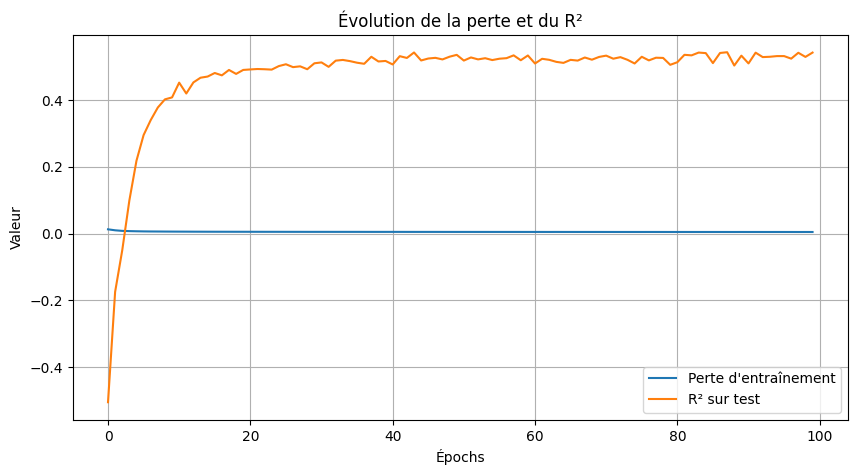

-20.86309757
15.68071073
tensor(4.7442)
tensor(0.7007)
tensor(13.7836)


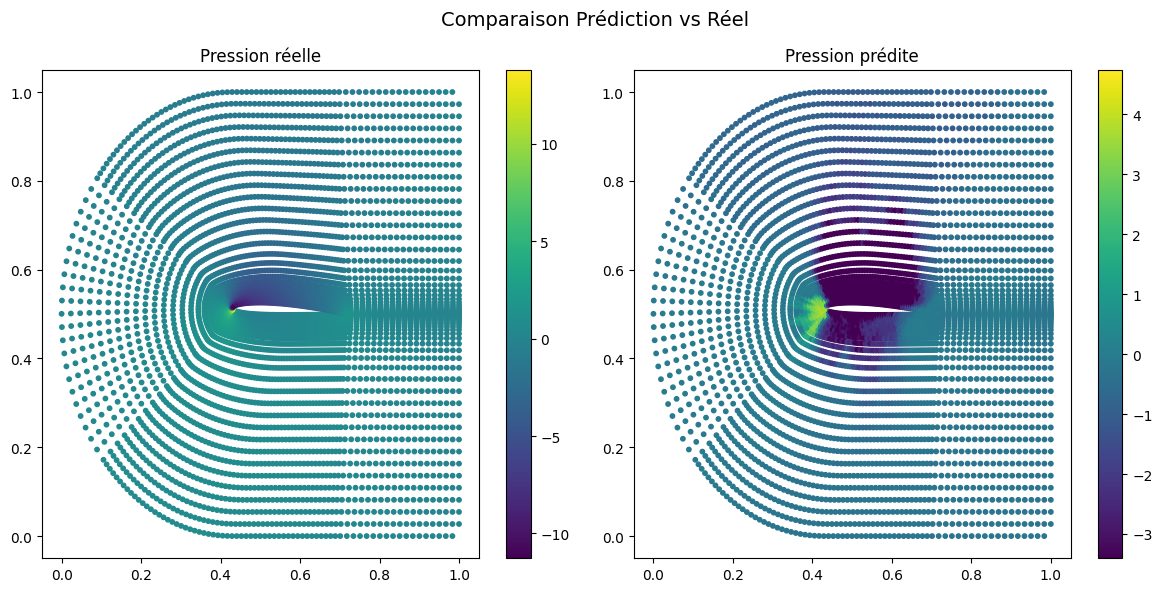

NameError: name 'plot_pressure_distribution' is not defined

In [96]:
# Évaluation finale
test_r2 = evaluate_gnn(model, test_loader)
print(f"R² sur les données test : {test_r2:.4f}")

# Affichage des courbes de perte et R²
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Perte d'entraînement")
plt.plot(test_r2_scores, label="R² sur test")
plt.xlabel("Épochs")
plt.ylabel("Valeur")
plt.title("Évolution de la perte et du R²")
plt.legend()
plt.grid()
plt.show()

# Sélectionner un graphe de test
test_graph = test_graphs[20]

# Faire une prédiction avec le modèle
model.eval()
with torch.no_grad():
    predictions = model(test_graph)

# Récupérer p_min et p_max pour la dénormalisation
p_min, p_max = p_range
print(p_min)
print(p_max)

# Affichage
plot_test_case(test_graph, predictions.squeeze(), p_min, p_max)

plot_pressure_distribution(train_graphs, title="Distribution des pressions normalisées (Train)")
